In [1]:
%pip install --upgrade pip
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
df = pd.read_csv("prices/AAPL.csv", index_col=0)
df.head()

,date,open,high,low,close,volume,dividends,stock_splits
idx,,,,,,,,
1,2021-04-15,70.000000,71.510002,63.000000,65.199997,11444400,0.0,0.0
2,2021-04-16,65.000000,65.199997,58.650002,61.000000,4199300,0.0,0.0
3,2021-04-19,60.000000,61.000000,55.705002,58.860001,4642500,0.0,0.0
4,2021-04-20,60.040001,61.900002,58.990002,60.150002,3055500,0.0,0.0
5,2021-04-21,60.490002,62.209999,56.526001,61.810001,3607100,0.0,0.0


In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cpu


In [5]:
from collections import deque
import random

class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, action_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen=1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        self.device = torch.device(DEVICE)
        self.model = DQNetwork(state_size, self.action_size).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-5)
        self.criterion = nn.MSELoss()

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.tensor(state, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d:t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0:t + 1]
        res = [block[i + 1] - block[i] for i in range(window_size - 1)]
        return np.array(res, dtype=np.float32)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.array([transition[0] for transition in mini_batch])
        actions = np.array([transition[1] for transition in mini_batch])
        rewards = np.array([transition[2] for transition in mini_batch])
        next_states = np.array([transition[3] for transition in mini_batch])
        dones = np.array([transition[4] for transition in mini_batch])

        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)

        current_q = self.model(states).gather(1, actions.unsqueeze(1)).squeeze()
        next_q = self.model(next_states).max(1)[0].detach()
        target_q = rewards + (1 - dones) * self.gamma * next_q

        loss = self.criterion(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self, episodes):
        for episode in range(episodes):
            state = self.get_state(0)
            total_profit = 0
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                reward = 0
                done = t == len(self.trend) - 2

                if action == 1 and t < (len(self.trend) - self.half_window):
                    self.inventory.append(self.trend[t])
                    reward = -self.trend[t]
                elif action == 2 and len(self.inventory) > 0:
                    bought_price = self.inventory.pop(0)
                    reward = self.trend[t] - bought_price
                    total_profit += reward

                self.memory.append((state, action, reward, next_state, done))
                state = next_state
                
                self.replay()

            print(f"Episode {episode + 1}/{episodes}, Total Profit: {total_profit}")

    def buy(self, initial_money):
        state = self.get_state(0)
        total_balance = initial_money
        states_buy = []
        states_sell = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            state = self.get_state(t + 1)
            if action == 1 and total_balance >= self.trend[t]:
                self.inventory.append(self.trend[t])
                total_balance -= self.trend[t]
                states_buy.append(t)

                print(f"Buying at {self.trend[t]} on time {t}, Balance: {total_balance}, Inventory: {len(self.inventory)}")
            elif action == 2 and len(self.inventory) > 0:
                bought_price = self.inventory.pop(0)
                total_balance += self.trend[t]
                states_sell.append(t)

                print(f"Selling at {self.trend[t]} on time {t}, Balance: {total_balance}, Inventory: {len(self.inventory)}")

        invest = ((total_balance - initial_money) / initial_money) * 100
        total_gains = total_balance - initial_money

        # return total_balance
        return states_buy, states_sell, total_gains, invest


In [6]:
close = df.close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size=window_size,
              window_size=window_size,
              trend=close,
              skip=skip,
              batch_size=batch_size)
agent.train(episodes=20)

Episode 1/20, Total Profit: 199.43503856630002
Episode 2/20, Total Profit: 46.97000598939999
Episode 3/20, Total Profit: 3.1699962615000015
Episode 4/20, Total Profit: -4.5799922941999895
Episode 5/20, Total Profit: 13.11000823989998
Episode 6/20, Total Profit: 29.30000591289999
Episode 7/20, Total Profit: -34.350013732799994
Episode 8/20, Total Profit: 11.489999771199994
Episode 9/20, Total Profit: -10.770002365200005
Episode 10/20, Total Profit: 105.9699983597
Episode 11/20, Total Profit: -0.7599983216000084
Episode 12/20, Total Profit: 4.540004730299991
Episode 13/20, Total Profit: -67.63000488289998
Episode 14/20, Total Profit: -0.09000015259999117
Episode 15/20, Total Profit: -1.2500047683999895
Episode 16/20, Total Profit: -8.299999237100007
Episode 17/20, Total Profit: 2.2199935913000175
Episode 18/20, Total Profit: 39.02000045770001
Episode 19/20, Total Profit: 0
Episode 20/20, Total Profit: 7.620018005399984


In [7]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

Buying at 63.7700004578 on time 208, Balance: 9936.2299995422, Inventory: 1
Selling at 56.2799987793 on time 210, Balance: 9992.5099983215, Inventory: 0
Buying at 36.1500015259 on time 616, Balance: 9956.3599967956, Inventory: 1
Selling at 37.3600006104 on time 621, Balance: 9993.719997406, Inventory: 0


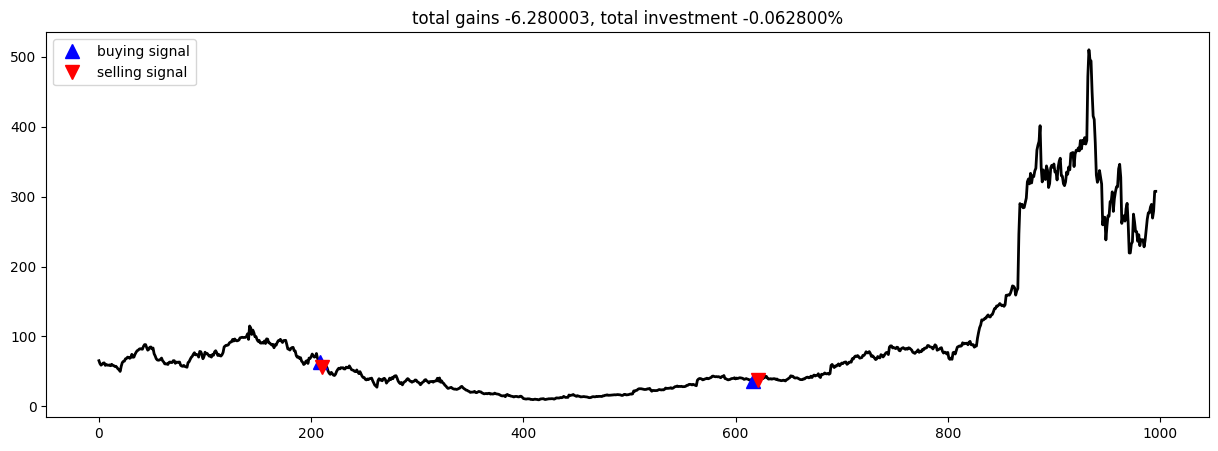

In [8]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='black', lw=2.)
plt.plot(close, '^', markersize=10, color='blue', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='red', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()